# Girvan Newman

In [1]:
import glob
import numpy as np
import networkx as nx
from os import listdir, chdir
from os.path import isfile, join

mypath = '../raccoon_proximity_weighted'
files = [mypath + '/' + f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [(int(f.split('_')[5].split('.')[0]), f) for f in files]
files.sort()

In [2]:
from networkx import edge_betweenness_centrality
from random import random
from itertools import islice
from networkx.algorithms.community.centrality import girvan_newman
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score

filt = [str(x) for x in range(16)]
final_pos = pd.read_csv('final_pos.csv', index_col='index')
final_pos.index = final_pos.index.map(str)
final_pos = dict(final_pos.apply(lambda x: np.array([x[0], x[1]]), axis=1))

def mve(G):
    # assume that the graph is already filtered
    mx = 0 
    for n in G.nodes():
        for w in G[n]:
            if G[n][w]['weight']>mx:
                mx = G[n][w]['weight']
                edge = (n , w)
    return edge

def comm(g, num_iter=1):
    gn_generator = girvan_newman(g, mve)
    gn_communities = next(islice(gn_generator, num_iter, None))

    gn_dict_communities = {}

    for i, c in enumerate(gn_communities):
        for node in c:
            gn_dict_communities[node] = i + 1

    for node in g:
        if node not in gn_dict_communities.keys():
            gn_dict_communities[node] = -1

    return gn_dict_communities

def d_mat(g):
    """Calculates the custom distance 1/(1 + log(interaction + 1))
        as a matrix for a graph
    
    Input:  Graph object g
           
    Output: Corrected log(s + 1) of interaction matrix"""
    A = nx.to_numpy_matrix(g)
    A = 1/(1+np.log(A + 1))
    np.fill_diagonal(A, 0)
    return A

def cluster_score(g, X, i):
    """Calculates the silhouette score for all the possible k clusters
    
    Input:  Graph object g
            Distance matrix X
            Number of iterations i
           
    Output: List with the silhouette scores"""
    l = np.array(list(comm(g, i).values()))
    if l[-1]==len(g):
        l[-1]=len(g) - 1
    s = silhouette_score(X, l, metric="precomputed")
    return s

def comm_auto(g, X):
    """Calculates the silhouette score for all iterations of the Girvan-Newman algorithm
    
    Input:  Graph object g
            Distance matrix X
           
    Output: Dict with labels of the cluster with the best score
            List with the silhouette scores"""
    n = 0
    i = 1
    max_score = -1
    while n<len(g):
        score = cluster_score(g, X, i)
        if score>max_score:
            max_i = i
            max_score = score
        n = max(comm(G, i).values())
        i +=1
    return comm(g, max_i)

In [3]:
#Save the communities of all weeks in a list
communities = []
for f in files:
    G = nx.read_graphml(f[1]).subgraph(filt)
    communities.append(comm_auto(G, d_mat(G)))
communities[4]

{'0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10,
 '10': 11,
 '11': 12,
 '12': 13,
 '13': 14,
 '14': 15,
 '15': 16}

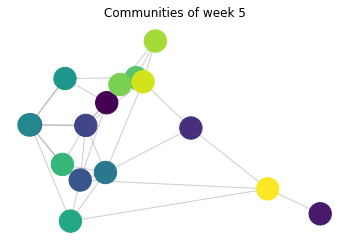

In [11]:
G = nx.read_graphml(files[4][1]).subgraph(filt)
p = pd.read_csv('pos_w5.csv', index_col=0)
p.index = p.index.map(str)
p = dict(p.apply(lambda x: np.array([x[0], x[1]]), axis=1))
nx.draw_networkx_nodes(G, p, node_color=list(communities[4].values()), node_size=500, label=G.nodes())
nx.draw_networkx_edges(G, p, alpha=0.2)
plt.axis('off')
plt.title('Communities of week 5')
plt.show()

In [5]:
from collections import Counter
c = {'iter':[], 'week':[],'std':[], 'score':[]}

for f in files:
    G = nx.read_graphml(f[1]).subgraph(filt)
    for i in range(1, len(G) - 6):
        c['iter'].append(i)
        c['week'].append(f[0])
        c['std'].append(np.std(list(Counter(comm(G, i).values()).values())))
        c['score'].append(cluster_score(G, d_mat(G), i))

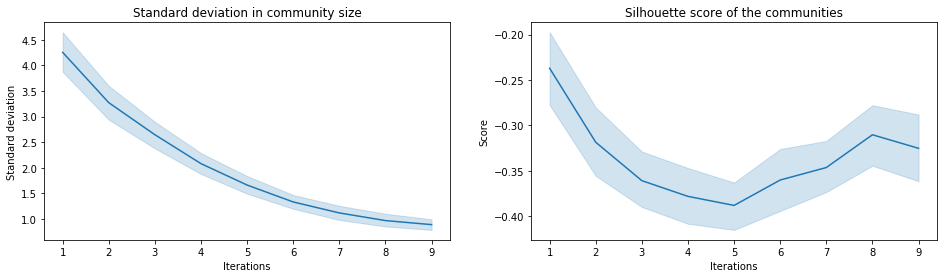

In [34]:
import seaborn as sns
fig, ax =plt.subplots(1,2, figsize=(16, 4))


sns.lineplot(c['iter'], c['std'], ax=ax[0])
ax[0].set_title("Standard deviation in community size")
ax[0].grid(False)
ax[0].set_ylabel('Standard deviation')    
ax[0].set_xlabel('Iterations')


sns.lineplot(c['iter'], c['score'], ax=ax[1])
ax[1].set_title("Silhouette score of the communities")
ax[1].grid(False)
ax[1].set_ylabel('Score')    
ax[1].set_xlabel('Iterations');

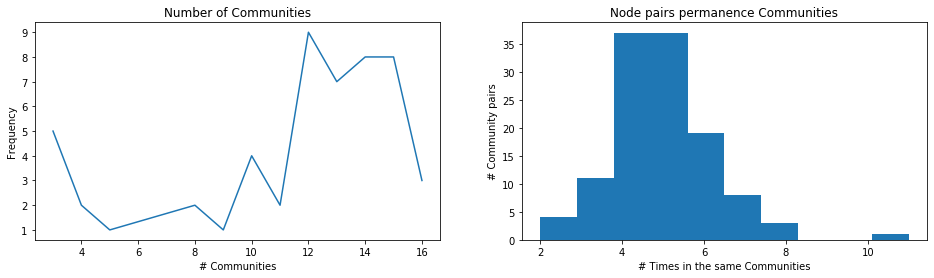

In [37]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16, 4))

#Plot Community size frequency
n_com = [max(c.values()) for c in communities]
n_com = Counter(n_com)
k = sorted(n_com)
n_com = [n_com[x] for x in k]
ax1 = plt.subplot(121)
ax1.plot(k, n_com)
ax1.set_title('Number of Communities')
ax1.set_xlabel('# Communities')
ax1.set_ylabel('Frequency')


#Plot node permanence in cluster
com_pairs = {(str(n), str(nn)):0 for n in range(15) for nn in range(n + 1, 16)}
for k in communities:
    for i in range(len(k)):
        for j in range(i + 1, len(k)):
            if list(k.values())[i]==list(k.values())[j]:
                mn = str(min(int(list(k.keys())[i]), int(list(k.keys())[j])))
                mx = str(max(int(list(k.keys())[i]), int(list(k.keys())[j])))
                com_pairs[mn, mx] += 1
ax2 = plt.subplot(122)
ax2.hist(com_pairs.values())
ax2.set_title('Node pairs permanence Communities')
ax2.set_xlabel('# Times in the same Communities')
ax2.set_ylabel('# Community pairs');

In [ ]:
import plotly.graph_objects as go

def create_edges(G, pos):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    return edge_trace

def create_nodes(G, pos):
    node_x = [-1]
    node_y = [-1]
    for p in pos.values():
        x, y = p
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(size=20,
            line_width=2))

    node_adjacencies = [0]
    node_text = ['na']
    c = comm(G, 5)
    for k in pos.keys():
        if k in G.nodes:
            node_adjacencies.append(c[k])
            node_text.append('Community: '+str(c[k]))
        else:
            node_adjacencies.append(0)
            node_text.append('Community: NA')

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text
    return node_trace

In [ ]:
weeks = list(range(1, 53))
x = [xx[0] for xx in final_pos.values()]
y = [xx[1] for xx in final_pos.values()]
# make figure
G = nx.read_graphml(files[0][1]).subgraph(filt)
fig_dict = {
    "data": [create_edges(G, final_pos), create_nodes(G, final_pos)],
    "layout": {},
    "frames": []
}

# fill in most of layout
fig_dict["layout"]['title'] = '<br>Evolution of communities through time'
fig_dict["layout"]['titlefont_size'] = 16
fig_dict["layout"]['showlegend'] = False
fig_dict["layout"]['hovermode'] = 'closest'
fig_dict["layout"]['margin'] = dict(b=20,l=5,r=5,t=40)
fig_dict["layout"]['xaxis'] = dict(showgrid=False, zeroline=False, showticklabels=False,
                                   range=[min(x)*1.1, max(x)*1.1])
fig_dict["layout"]['yaxis'] = dict(showgrid=False, zeroline=False, showticklabels=False,
                                   range=[min(y)*1.1, max(y)*1.1])

fig_dict["layout"]["sliders"] = {
    "args": [
        "transition", {
            "duration": 400,
            "easing": "cubic-in-out"
        }
    ],
    "initialValue": "1",
    "plotlycommand": "animate",
    "values": weeks,
    "visible": True
}
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 1000, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Week:",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 300, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

#Update the data and frames

for f in files:
    G = nx.read_graphml(f[1]).subgraph(filt)
    frame = {"data": [create_edges(G, final_pos), create_nodes(G, final_pos)], "name": f[0]}
    fig_dict["frames"].append(frame)
    slider_step = {"args": [
        [f[0]],
        {"frame": {"duration": 300, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 300}}
    ],
        "label": f[0],
        "method": "animate"}
    sliders_dict["steps"].append(slider_step)
    
fig_dict["layout"]["sliders"] = [sliders_dict]

fig = go.Figure(fig_dict)

fig.show()